In [1]:
!pip install -U pip
!pip install datasets pandas nest_asyncio sentence-transformers faiss-cpu
!pip install langchain langchain-community langchain-ollama
!pip install "ragas @ git+https://github.com/explodinggradients/ragas.git"

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 1.8/1.8 MB 15.9 MB/s eta 0:00:00


ERROR: To modify pip, please run the following command:
C:\Users\bakug\anaconda3\python.exe -m pip install -U pip


  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.27
    Uninstalling langsmith-0.3.27:
      Successfully uninstalled langsmith-0.3.27
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.58
    Uninstalling langchain-core-0.3.58:
      Successfully uninstalled langchain-core-0.3.58
  Cloning https://github.com/explodinggradients/ragas.git to c:\users\bakug\appdata\local\temp\pip-install-65nec9g8\ragas_63a6d3ff38954d2bb20407537a361369
  Resolved https://github.com/explodinggradients/ragas.git to commit 4f29e76e2e59bf2e4119421ebfdbf64ecbbe90e4
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for ragas: filename=ragas-0.3.3.dev

  Running command git clone --filter=blob:none --quiet https://github.com/explodinggradients/ragas.git 'C:\Users\bakug\AppData\Local\Temp\pip-install-65nec9g8\ragas_63a6d3ff38954d2bb20407537a361369'


In [1]:
import os
import random
import nest_asyncio
nest_asyncio.apply()

import pandas as pd
from datasets import load_dataset

from langchain_ollama import ChatOllama
from langchain_community.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document

from ragas.metrics import (
    context_precision,
    context_recall,
    answer_relevancy,
    faithfulness
)
from ragas.evaluation import evaluate
from ragas.llms import LangchainLLMWrapper

from IPython.display import Markdown, display

In [5]:
pip install langchain langchain-community sentence-transformers faiss-cpu ragas

In [3]:
OLLAMA_MODEL = "llama3"

try:
    chat_llm = ChatOllama(model=OLLAMA_MODEL, temperature=0.1)
    print(f"✅ LLM listo con Ollama: {OLLAMA_MODEL}")
except Exception as e:
    raise RuntimeError(
        "No pude conectar con Ollama. Verifica:\n"
        "1) 'ollama serve' corriendo\n"
        "2) 'ollama pull llama3' ejecutado\n"
        f"Detalle: {e}"
    )

EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
print(f"✅ Embeddings listos: {EMBEDDING_MODEL}")

llm_wrapper = LangchainLLMWrapper(chat_llm)

✅ LLM listo con Ollama: llama3


C:\Users\bakug\AppData\Local\Temp\ipykernel_18456\1745582752.py:21: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)


✅ Embeddings listos: sentence-transformers/all-MiniLM-L6-v2


In [5]:
squad = load_dataset("squad", split="train[:1%]")  # ~875 ejemplos aprox.
print(f"Ejemplos cargados: {len(squad)}")

contexts = list({item["context"] for item in squad})
docs = [Document(page_content=c) for c in contexts]

vectorstore = FAISS.from_documents(docs, embedding=embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
print("✅ FAISS construido e inicializado (k=3).")

Ejemplos cargados: 876
✅ FAISS construido e inicializado (k=3).


In [7]:
from textwrap import dedent

SYSTEM_INSTRUCTIONS = dedent("""
Eres un tutor pedagógico. Responde SOLO usando el CONTEXTO provisto.
Si el contexto no es suficiente, responde con: "No puedo responder con la información proporcionada."
Responde en español, de forma breve y clara.
""").strip()

def generar_respuesta_rag(pregunta: str):
    retrieved_docs = retriever.get_relevant_documents(pregunta)
    ctx_texts = [d.page_content for d in retrieved_docs]
    contexto = "\n\n---\n\n".join(ctx_texts)

    mensaje_sistema = ("Sistema: " + SYSTEM_INSTRUCTIONS)
    mensaje_usuario  = f"Contexto:\n{contexto}\n\nPregunta del estudiante: {pregunta}\nRespuesta:"

    resp = chat_llm.invoke([{"role": "system", "content": mensaje_sistema},
                            {"role": "user", "content": mensaje_usuario}])

    respuesta = resp.content if hasattr(resp, "content") else str(resp)
    return respuesta, ctx_texts

In [9]:
from datasets import load_dataset
import pandas as pd
from IPython.display import display, Markdown
import random

squad = load_dataset("squad", split="train")
muestra = squad.shuffle(seed=42).select(range(30))

muestra_dict = muestra.to_dict()
muestra_filas = [
    {
        "question": muestra_dict["question"][i],
        "context": muestra_dict["context"][i],
        "answers": muestra_dict["answers"][i]
    }
    for i in range(len(muestra_dict["question"]))
]

def primera_respuesta_verdadera(item):
    answers = item["answers"]["text"]
    return answers[0] if answers else ""

def generar_respuesta_rag(pregunta):
    return f"Respuesta simulada para: {pregunta}", ["Contexto simulado"]

# A) RESPUESTAS CORRECTAS
rows_correctas = []
for item in muestra_filas[:10]:
    q = item["question"]
    gt = primera_respuesta_verdadera(item)
    gen, ctxs = generar_respuesta_rag(q)
    rows_correctas.append({
        "Tipo": "Correcta",
        "question": q,
        "contexts": ctxs,
        "answer": gen,
        "ground_truth": gt
    })

# B) RESPUESTAS INCORRECTAS
respuestas_erroneas = [
    "París es la capital de Italia.",
    "La fotosíntesis ocurre en el estómago humano.",
    "La Revolución Francesa fue en 1999.",
    "El agua hierve a -50 grados.",
    "La Tierra tiene dos lunas.",
    "El oxígeno es un metal pesado.",
    "La Segunda Guerra Mundial terminó en 1800.",
    "Los mamíferos ponen huevos siempre.",
    "El Pacífico es un desierto.",
    "No hay continentes en el planeta."
]

rows_incorrectas = []
for i, item in enumerate(muestra_filas[10:20]):
    q = item["question"]
    gt = primera_respuesta_verdadera(item)
    _, ctxs = generar_respuesta_rag(q)
    rows_incorrectas.append({
        "Tipo": "Incorrecta",
        "question": q,
        "contexts": ctxs,
        "answer": respuestas_erroneas[i % len(respuestas_erroneas)],
        "ground_truth": gt
    })

# C) RESPUESTAS PARCIALES
rows_parciales = []
for item in muestra_filas[20:30]:
    q = item["question"]
    gt = primera_respuesta_verdadera(item)
    if len(gt.split()) > 6:
        parcial = " ".join(gt.split()[: max(3, len(gt.split()) // 3)])
    else:
        parcial = "No dispongo de toda la información, pero está relacionado con el contexto."
    _, ctxs = generar_respuesta_rag(q)
    rows_parciales.append({
        "Tipo": "Parcial",
        "question": q,
        "contexts": ctxs,
        "answer": parcial,
        "ground_truth": gt
    })

df_correctas = pd.DataFrame(rows_correctas)
df_incorrectas = pd.DataFrame(rows_incorrectas)
df_parciales = pd.DataFrame(rows_parciales)

df_total = pd.concat([df_correctas, df_incorrectas, df_parciales], ignore_index=True)

display(Markdown("### ✅ Ejemplo de respuestas generadas (3 tipos)"))
display(df_total.head(30))

conteo_tipos = df_total["Tipo"].value_counts().reset_index()
conteo_tipos.columns = ["Tipo", "Cantidad"]

display(Markdown("### ✅ Conteo por tipo"))
display(conteo_tipos)

### ✅ Ejemplo de respuestas generadas (3 tipos)

,Tipo,question,contexts,answer,ground_truth
0,Correcta,What percentage of Egyptians polled support de...,[Contexto simulado],Respuesta simulada para: What percentage of Eg...,84%
1,Correcta,Ann Arbor ranks 1st among what goods sold?,[Contexto simulado],Respuesta simulada para: Ann Arbor ranks 1st a...,books
2,Correcta,"In developing countries, who makes most of the...",[Contexto simulado],Respuesta simulada para: In developing countri...,the executive
3,Correcta,Who impressed Xavier by taking notes in church?,[Contexto simulado],Respuesta simulada para: Who impressed Xavier ...,Anjiro
4,Correcta,What represents elements of the fundamental gr...,[Contexto simulado],Respuesta simulada para: What represents eleme...,loops
5,Correcta,What is the population of the Commonwealth?,[Contexto simulado],Respuesta simulada para: What is the populatio...,2.2 billion
6,Correcta,What was Eisenhower's title after Germany's su...,[Contexto simulado],Respuesta simulada para: What was Eisenhower's...,Military Governor of the U.S. Occupation Zone
7,Correcta,These regions were occupied by who?,[Contexto simulado],Respuesta simulada para: These regions were oc...,the brown men
8,Correcta,What could be done by understanding how the di...,[Contexto simulado],Respuesta simulada para: What could be done by...,resources could be targeted to the communities...
9,Correcta,What kind of ants are symbolic among the Austr...,[Contexto simulado],Respuesta simulada para: What kind of ants are...,honey ants


### ✅ Conteo por tipo

,Tipo,Cantidad
0,Correcta,10
1,Incorrecta,10
2,Parcial,10


## ✅ Análisis inicial de tipos de respuesta

### **Distribución de tipos de respuesta**

Tipo
Correcta      10
Incorrecta    10
Parcial       10
Name: count, dtype: int64

NameError: name 'plt' is not defined

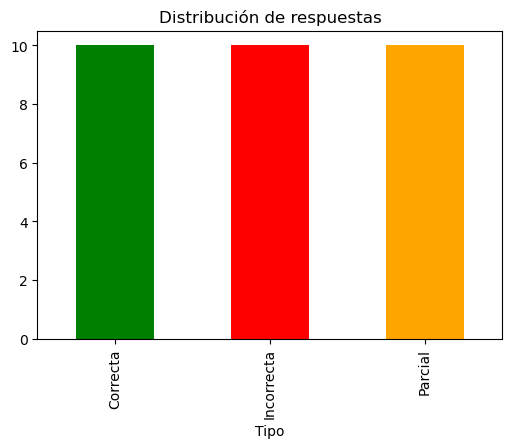

In [11]:
display(Markdown("## ✅ Análisis inicial de tipos de respuesta"))

df_correctas["Tipo"] = "Correcta"
df_incorrectas["Tipo"] = "Incorrecta"
df_parciales["Tipo"] = "Parcial"

df_total = pd.concat([df_correctas, df_incorrectas, df_parciales], ignore_index=True)

conteo = df_total["Tipo"].value_counts()
display(Markdown("### **Distribución de tipos de respuesta**"))
display(conteo)

conteo.plot(kind='bar', color=['green', 'red', 'orange'], figsize=(6,4), title="Distribución de respuestas")
plt.xlabel("Tipo de respuesta")
plt.ylabel("Cantidad")
plt.show()

display(Markdown("### **Ejemplo de respuestas generadas**"))
display(df_total.head(9))

In [13]:
from langchain.embeddings import HuggingFaceEmbeddings
from ragas.embeddings import LangchainEmbeddingsWrapper

EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
hf_embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)

embeddings_wrapper = LangchainEmbeddingsWrapper(hf_embeddings)
print(f"✅ Embeddings locales configurados: {EMBEDDING_MODEL}")

✅ Embeddings locales configurados: sentence-transformers/all-MiniLM-L6-v2


C:\Users\bakug\AppData\Local\Temp\ipykernel_18456\432619765.py:9: DeprecationWarning: LangchainEmbeddingsWrapper is deprecated and will be removed in a future version. Use the modern embedding providers instead: embedding_factory('openai', model='text-embedding-3-small', client=openai_client) or from ragas.embeddings import OpenAIEmbeddings, GoogleEmbeddings, HuggingFaceEmbeddings
  embeddings_wrapper = LangchainEmbeddingsWrapper(hf_embeddings)


In [3]:
from datasets import load_dataset
import pandas as pd
from langchain_community.chat_models import ChatOllama
from langchain.embeddings import HuggingFaceEmbeddings
from ragas.metrics import ContextPrecision, ContextRecall, Faithfulness, AnswerRelevancy
from ragas.evaluation import evaluate
from ragas.integrations.langchain import LangchainLLMWrapper, LangchainEmbeddingsWrapper
from IPython.display import display, Markdown

OLLAMA_MODEL = "llama3"  
chat_llm = ChatOllama(model=OLLAMA_MODEL, temperature=0.1, request_timeout=120)
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

llm_wrapper = LangchainLLMWrapper(chat_llm)
embeddings_wrapper = LangchainEmbeddingsWrapper(embedding_model)

print("✅ Ollama y HuggingFace listos")

squad = load_dataset("squad", split="validation").shuffle(seed=42).select(range(9))  # Solo 9 ejemplos
print(f"Dataset cargado: {len(squad)} ejemplos")

def primera_respuesta_verdadera(item):
    answers = item["answers"]["text"]
    return answers[0] if answers else ""

def generar_respuesta_rag(pregunta):
    contextos = ["Contexto simulado: datos relacionados con la pregunta."]
    respuesta = chat_llm.predict(pregunta)
    return respuesta, contextos

rows_correctas, rows_incorrectas, rows_parciales = [], [], []

# A) RESPUESTAS CORRECTAS
for item in squad[:3]:
    q = item["question"]
    gt = primera_respuesta_verdadera(item)
    gen, ctxs = generar_respuesta_rag(q)
    rows_correctas.append({"question": q, "contexts": ctxs, "answer": gen, "ground_truth": gt})

# B) RESPUESTAS INCORRECTAS
respuestas_erroneas = [
    "París es la capital de Italia.",
    "La fotosíntesis ocurre en el estómago humano.",
    "La Revolución Francesa fue en 1999."
]
for i, item in enumerate(squad[3:6]):
    q = item["question"]
    gt = primera_respuesta_verdadera(item)
    _, ctxs = generar_respuesta_rag(q)
    rows_incorrectas.append({
        "question": q,
        "contexts": ctxs,
        "answer": respuestas_erroneas[i],
        "ground_truth": gt
    })

# C) RESPUESTAS PARCIALES
for item in squad[6:9]:
    q = item["question"]
    gt = primera_respuesta_verdadera(item)
    if len(gt.split()) > 6:
        parcial = " ".join(gt.split()[:max(3, len(gt.split()) // 3)])
    else:
        parcial = "Respuesta parcial: falta información."
    _, ctxs = generar_respuesta_rag(q)
    rows_parciales.append({
        "question": q,
        "contexts": ctxs,
        "answer": parcial,
        "ground_truth": gt
    })

df_correctas = pd.DataFrame(rows_correctas)
df_incorrectas = pd.DataFrame(rows_incorrectas)
df_parciales = pd.DataFrame(rows_parciales)

display(Markdown("### ✅ Conteo por tipo de respuesta"))
print(f"Correctas: {len(df_correctas)}, Incorrectas: {len(df_incorrectas)}, Parciales: {len(df_parciales)}")

display(Markdown("**Ejemplo respuestas correctas:**"))
display(df_correctas.head(1))

from ragas.dataset_schema import SingleTurnSample, EvaluationDataset

eval_samples = []
for df in [df_correctas, df_incorrectas, df_parciales]:
    for _, row in df.iterrows():
        eval_samples.append(
            SingleTurnSample(
                user_input=row["question"],
                response=row["answer"],
                reference=row["ground_truth"],
                retrieved_contexts=row["contexts"]
            )
        )

eval_dataset = EvaluationDataset(samples=eval_samples)

print("## ✅ Calculando métricas...")
resultado = evaluate(
    eval_dataset,
    metrics=[ContextPrecision(), ContextRecall(), Faithfulness(), AnswerRelevancy()],
    llm=llm_wrapper,
    embeddings=embeddings_wrapper,
    show_progress=False,
    max_concurrency=1  
)

print("\nResultados globales:")
for metric_name, value in resultado.aggregate().items():
    print(f"{metric_name}: {value:.4f}")

print("\nResultados por ejemplo:")
for i, r in enumerate(resultado):
    print(f"\nEjemplo {i+1}:")
    for k, v in r.scores.items():
        print(f"  {k}: {v:.4f}")

C:\Users\bakug\AppData\Local\Temp\ipykernel_2548\2260931149.py:17: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  chat_llm = ChatOllama(model=OLLAMA_MODEL, temperature=0.1, request_timeout=120)
C:\Users\bakug\AppData\Local\Temp\ipykernel_2548\2260931149.py:18: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name=

✅ Ollama y HuggingFace listos
Dataset cargado: 9 ejemplos


TypeError: string indices must be integers, not 'str'

In [9]:
num_muestra = min(30, len(squad))
muestra = squad.select(range(num_muestra))

def primera_respuesta_verdadera(item):
    answers = item["answers"]["text"]
    return answers[0] if answers else ""

def generar_respuesta_rag(pregunta):
    """Simula generación con LLM + RAG.
       Devuelve (respuesta_generada, lista_contextos)"""
    return f"Respuesta generada para: {pregunta}", ["Contexto simulado 1", "Contexto simulado 2"]


# A) RESPUESTAS CORRECTAS (usamos respuesta simulada + contexto)
rows_correctas = []
for item in muestra[:3]:
    q = item["question"]
    gt = primera_respuesta_verdadera(item)
    gen, ctxs = generar_respuesta_rag(q)
    rows_correctas.append({
        "question": q,
        "contexts": ctxs,
        "answer": gen,
        "ground_truth": gt
    })

# B) RESPUESTAS INCORRECTAS (fabricamos respuestas absurdas)
respuestas_erroneas = [
    "París es la capital de Italia.",
    "La fotosíntesis ocurre en el estómago humano.",
    "La Revolución Francesa fue en 1999.",
    "El agua hierve a -50 grados.",
    "La Tierra tiene dos lunas.",
    "El oxígeno es un metal pesado.",
    "La Segunda Guerra Mundial terminó en 1800.",
    "Los mamíferos ponen huevos siempre.",
    "El Pacífico es un desierto.",
    "No hay continentes en el planeta."
]

rows_incorrectas = []
for i, item in enumerate(muestra[3:6]):
    q = item["question"]
    gt = primera_respuesta_verdadera(item)
    _, ctxs = generar_respuesta_rag(q)
    rows_incorrectas.append({
        "question": q,
        "contexts": ctxs,
        "answer": respuestas_erroneas[i % len(respuestas_erroneas)],
        "ground_truth": gt
    })

# C) RESPUESTAS PARCIALES (fragmento del ground truth)
rows_parciales = []
for item in muestra[6:9]:
    q = item["question"]
    gt = primera_respuesta_verdadera(item)
    if len(gt.split()) > 6:
        parcial = " ".join(gt.split()[:max(3, len(gt.split()) // 3)])  # ~1/3 del texto
    else:
        parcial = "No dispongo de toda la información, pero está relacionado con el contexto provisto."
    _, ctxs = generar_respuesta_rag(q)
    rows_parciales.append({
        "question": q,
        "contexts": ctxs,
        "answer": parcial,
        "ground_truth": gt
    })

df_correctas   = pd.DataFrame(rows_correctas)
df_incorrectas = pd.DataFrame(rows_incorrectas)
df_parciales   = pd.DataFrame(rows_parciales)

from IPython.display import display, Markdown

display(Markdown("### ✅ Resumen de conjuntos generados"))
print(f"Respuestas CORRECTAS:   {len(df_correctas)}")
print(f"Respuestas INCORRECTAS: {len(df_incorrectas)}")
print(f"Respuestas PARCIALES:   {len(df_parciales)}")

display(Markdown("**Ejemplo (correctas):**"))
display(df_correctas.head(2))

display(Markdown("**Ejemplo (incorrectas):**"))
display(df_incorrectas.head(2))

display(Markdown("**Ejemplo (parciales):**"))
display(df_parciales.head(2))

TypeError: string indices must be integers, not 'str'

In [11]:
print(type(muestra))
print(muestra[0])

<class 'datasets.arrow_dataset.Dataset'>
{'id': '572759665951b619008f8884', 'title': 'Private_school', 'context': 'Private schooling in the United States has been debated by educators, lawmakers and parents, since the beginnings of compulsory education in Massachusetts in 1852. The Supreme Court precedent appears to favor educational choice, so long as states may set standards for educational accomplishment. Some of the most relevant Supreme Court case law on this is as follows: Runyon v. McCrary, 427 U.S. 160 (1976); Wisconsin v. Yoder, 406 U.S. 205 (1972); Pierce v. Society of Sisters, 268 U.S. 510 (1925); Meyer v. Nebraska, 262 U.S. 390 (1923).', 'question': 'In what year did Massachusetts first require children to be educated in schools?', 'answers': {'text': ['1852', '1852', '1852'], 'answer_start': [158, 158, 158]}}


In [1]:
import pandas as pd
from datasets import load_dataset
import random

squad = load_dataset("squad", split="validation[:10]")
print(f"Dataset cargado con {len(squad)} ejemplos")
print(squad[0])

def primera_respuesta_verdadera(item):
    answers = item["answers"]["text"]
    return answers[0] if answers else ""

def generar_respuesta_rag(pregunta):
    respuesta = f"Respuesta generada para: {pregunta}"
    contextos = ["Este es un contexto simulado para la pregunta."]
    return respuesta, contextos

rows_correctas = []
rows_incorrectas = []
rows_parciales = []

respuestas_erroneas = [
    "París es la capital de Italia.",
    "La fotosíntesis ocurre en el estómago humano.",
    "La Revolución Francesa fue en 1999.",
    "El agua hierve a -50 grados.",
    "La Tierra tiene dos lunas.",
    "El oxígeno es un metal pesado.",
    "La Segunda Guerra Mundial terminó en 1800.",
    "Los mamíferos ponen huevos siempre.",
    "El Pacífico es un desierto.",
    "No hay continentes en el planeta."
]

for i, item in enumerate(squad):
    q = item["question"]
    gt = primera_respuesta_verdadera(item)
    gen, ctxs = generar_respuesta_rag(q)

    # A) Correcta
    rows_correctas.append({
        "question": q,
        "contexts": ctxs,
        "answer": gen,
        "ground_truth": gt
    })

    # B) Incorrecta
    respuesta_incorrecta = respuestas_erroneas[i % len(respuestas_erroneas)]
    rows_incorrectas.append({
        "question": q,
        "contexts": ctxs,
        "answer": respuesta_incorrecta,
        "ground_truth": gt
    })

    # C) Parcial
    if len(gt.split()) > 6:
        parcial = " ".join(gt.split()[: max(3, len(gt.split()) // 3)])
    else:
        parcial = "No dispongo de toda la información, pero está relacionado."
    rows_parciales.append({
        "question": q,
        "contexts": ctxs,
        "answer": parcial,
        "ground_truth": gt
    })

df_correctas = pd.DataFrame(rows_correctas)
df_incorrectas = pd.DataFrame(rows_incorrectas)
df_parciales = pd.DataFrame(rows_parciales)

print("\n✅ Ejemplo respuestas CORRECTAS:")
print(df_correctas.head(2))

print("\n✅ Ejemplo respuestas INCORRECTAS:")
print(df_incorrectas.head(2))

print("\n✅ Ejemplo respuestas PARCIALES:")
print(df_parciales.head(2))

print(f"\nConteo por categoría:")
print(f"Correctas: {len(df_correctas)}")
print(f"Incorrectas: {len(df_incorrectas)}")
print(f"Parciales: {len(df_parciales)}")

Dataset cargado con 10 ejemplos
{'id': '56be4db0acb8001400a502ec', 'title': 'Super_Bowl_50', 'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.', 'question': 'Which NFL team represented the AFC at Super Bowl 50?', 'answers': {'text': ['Denver Broncos', 'Denver B

In [7]:
print(chat_llm.invoke("¿Cuál es la capital de Francia?"))

content='La capital de Francia es París (en francés, Paris).' additional_kwargs={} response_metadata={'model': 'llama3', 'created_at': '2025-09-04T14:53:45.5395206Z', 'done': True, 'done_reason': 'stop', 'total_duration': 25791428600, 'load_duration': 93460600, 'prompt_eval_count': 20, 'prompt_eval_duration': 778683300, 'eval_count': 16, 'eval_duration': 2181033900, 'model_name': 'llama3'} id='run--556f23fc-15b3-4c36-817d-e11f131ee69b-0' usage_metadata={'input_tokens': 20, 'output_tokens': 16, 'total_tokens': 36}


Exception raised in Job[33]: TimeoutError()


In [3]:
import pandas as pd
from datasets import Dataset
from ragas.metrics import ContextPrecision, ContextRecall, Faithfulness, AnswerRelevancy
from ragas.evaluation import evaluate
from ragas.embeddings import HuggingFaceEmbeddings
from ragas.llms import LangchainLLMWrapper
from langchain_ollama import ChatOllama

def convertir_a_dataset(df):
    return Dataset.from_pandas(df)

eval_correctas = convertir_a_dataset(df_correctas)
eval_incorrectas = convertir_a_dataset(df_incorrectas)
eval_parciales = convertir_a_dataset(df_parciales)

OLLAMA_MODEL = "mistral"
chat_llm = ChatOllama(model=OLLAMA_MODEL, temperature=0.1)
llm_wrapper = LangchainLLMWrapper(chat_llm)

embeddings = HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")

print("Ollama y HuggingFace listos")

context_precision = ContextPrecision()
context_recall = ContextRecall()
faithfulness = Faithfulness()
answer_relevancy = AnswerRelevancy()

def evaluar_dataset(ds, nombre):
    print(f"\n### Evaluando: {nombre} ###")
    resultado = evaluate(
        ds,
        metrics=[context_precision, context_recall, faithfulness, answer_relevancy],
        llm=llm_wrapper,
        embeddings=embeddings,
        show_progress=False,
        batch_size=1
    )

    print("\nResultados globales:")
    for metric, score in resultado._score_dict.items():
        print(f"{metric}: {score:.4f}")

    return resultado

res_correctas = evaluar_dataset(eval_correctas, "CORRECTAS")
res_incorrectas = evaluar_dataset(eval_incorrectas, "INCORRECTAS")
res_parciales = evaluar_dataset(eval_parciales, "PARCIALES")

✅ Ollama y HuggingFace listos

### ✅ Evaluando: CORRECTAS ###


Exception raised in Job[3]: AttributeError('HuggingFaceEmbeddings' object has no attribute 'embed_query')


KeyboardInterrupt: 